<a href="https://colab.research.google.com/github/qriovider/queueing_delayed_disptaching/blob/main/queueing_simulation_delayed_dispatching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Queueing model with delayed dispatching**

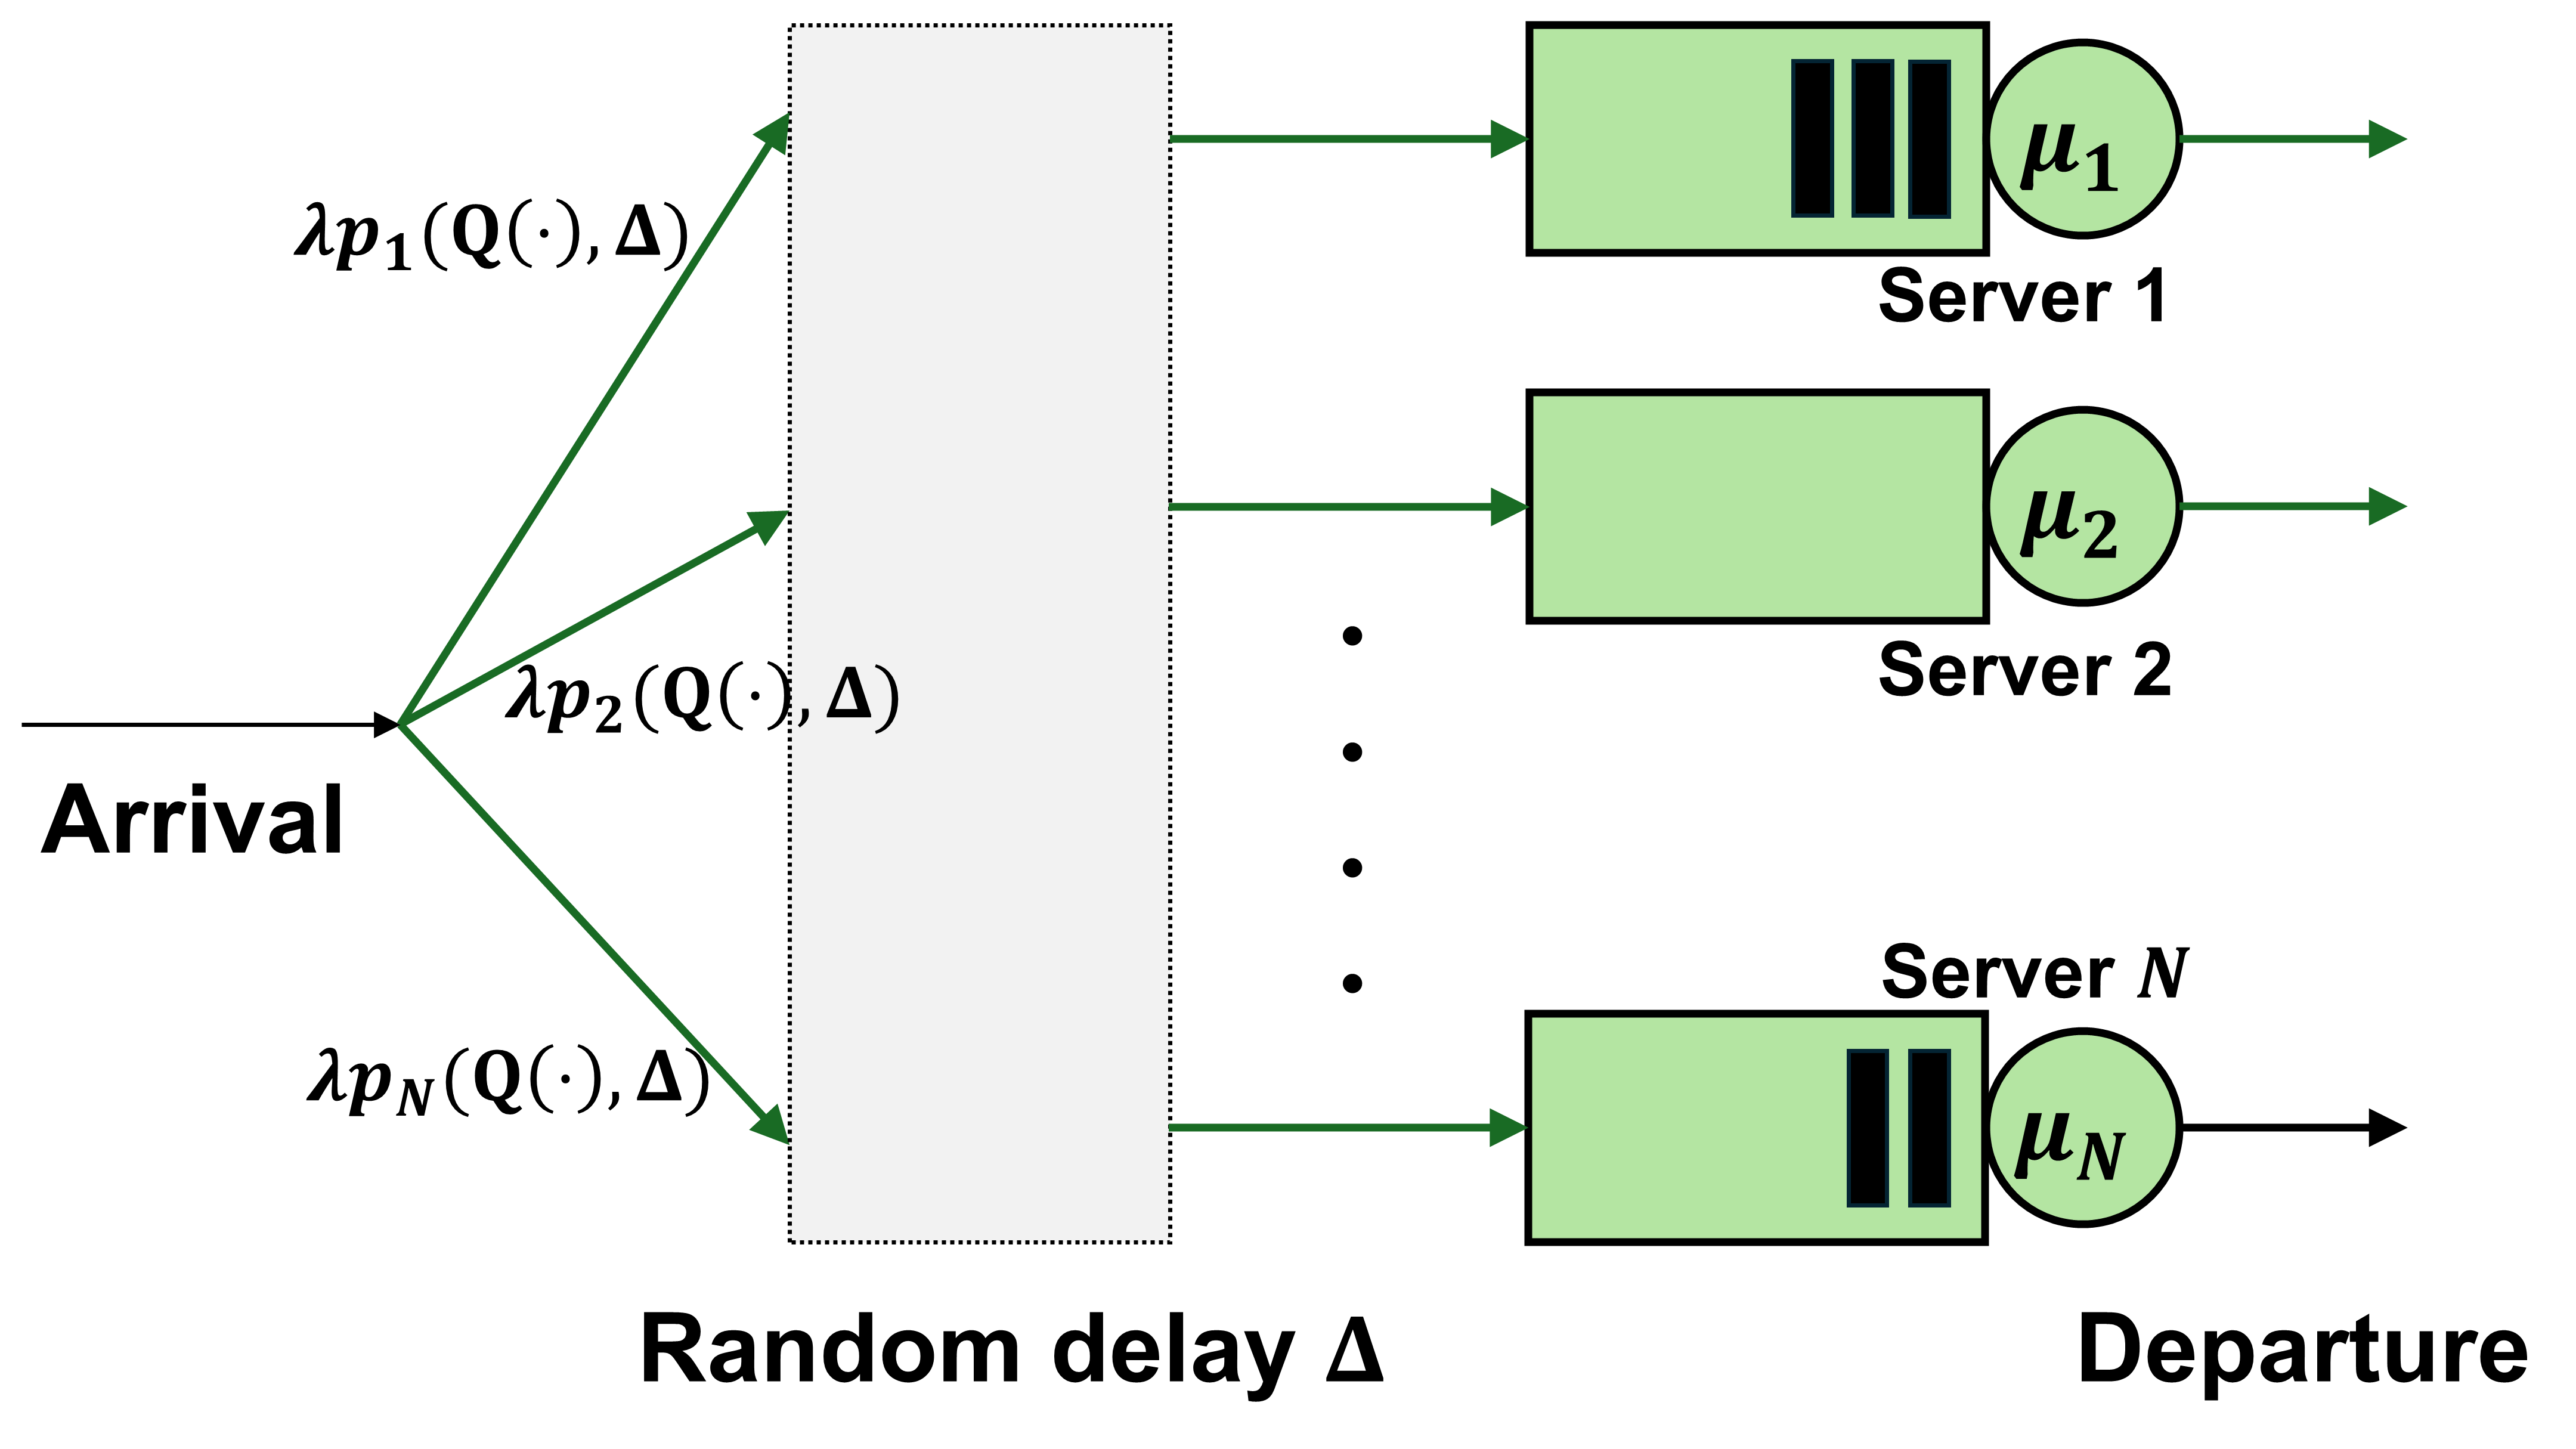

In [1]:
!pip install simpy

In [2]:
import simpy
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [23]:
obs_times = []
queue1 = []
queue2 = []
completed = []
time = []
ave_queue = []

def generate_interarrival(lam):
  return np.random.exponential(1./lam)

def generate_service(mu):
  return np.random.exponential(1./mu)

def multinomial_logit(utilities, theta):
  utilities = np.array(utilities)
  scaled_utilities = - theta * utilities
  exp_utilities = np.exp(scaled_utilities - np.max(scaled_utilities))  # for numerical stability
  probabilities = exp_utilities / np.sum(exp_utilities)
  return probabilities

def JSQ(s, d):  # join the shortest queue from sampled queue
  rng = np.random.default_rng()
  arr = rng.choice(s, d, replace=False, shuffle=True) #, shuffle=False)
  m = min(arr)  # the queue length of the server to which the job will be assigned
  u = s.index(m)  # the server that is assigned to an arriving job
  return u

def arriving(env, counters, theta, delta):
  i = 0
  while True:
    i = i + 1
    yield env.timeout(generate_interarrival(N*lam))
    env.process(customer(env, i, counters, theta, delta))

def Queue_list(counters):
  return np.array([NumInSystem(counters[k]) for k in range(len(counters))])

def customer(env, i, counters, theta, delta):
  arrive = env.now
  Qlength = Queue_list(counters)
  for k in range(len(Qlength)):  # JSQ
    if Qlength[k] == 0 or Qlength[k] == min(Qlength):
      choice = k  # the customer chooses a server which has the minimum number of queues
      break
  #choice = np.random.randint(N)  # random allocation
  #probs = multinomial_logit(Qlength, theta)  # multi-logit model
  #choice = np.random.choice(len(Qlength), p=probs)
  before = len(counters[choice].queue)
  yield env.timeout(delta)
  with counters[choice].request() as req:
    # the customer wait for the counter
    yield req
    wait = env.now - arrive
    # the customer receives a service
    yield env.timeout(generate_service(mu))
  completed.append(env.now - arrive)

def NumInSystem(R):
    # Total number of customers in the resource R
    return np.max([0, len(R.put_queue) + len(R.users)])

def observe_delay(env, counters, theta):
  while True:
    obs_times.append(env.now)
    ave_queue.append(np.mean(Queue_list(counters)))
    queue1.append(NumInSystem(counters[0]))
    queue2.append(NumInSystem(counters[1]))
    yield env.timeout(0.1)

In [9]:
def sim_heterogeneous_delay(k, TIME, lam, mu_1, N, theta, delta):
  np.random.seed(k)
  env = simpy.Environment()
  counters = []
  for i in range(N):
    counters.append(simpy.Resource(env, capacity=1))
  env.process(arriving(env, counters, theta, delta))
  env.process(observe_delay(env, counters, theta))
  env.run(until=TIME)

In [24]:
TIME = 400
N = 2
lam = 0.70
mu = 1.0
delta = 10
theta = 0

sim_heterogeneous_delay(0, TIME, lam, mu, N, theta, delta)

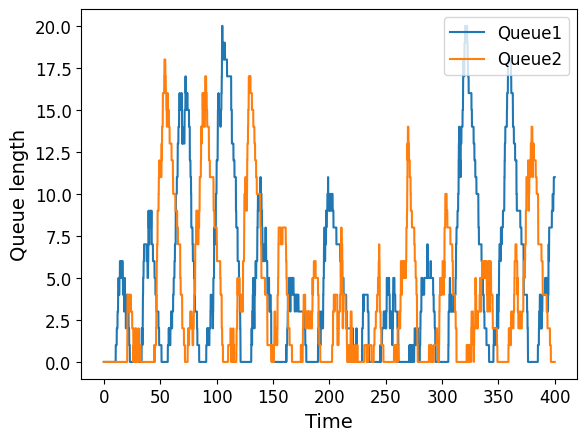

In [25]:
plt.plot(obs_times, queue1, label="Queue1")
plt.plot(obs_times, queue2, label="Queue2")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Queue length", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="upper right", )
plt.show()